# [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) with [Qiskit](https://qiskit.org/documentation/stable/0.19/index.html)


It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
Credit card fraud detection is a crucial use case in the financial industry and is taken from [the kaggle competition](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).


This notebook is inspired by [the Qiskit Machine Learning tutorial](https://qiskit.org/ecosystem/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, copy, warnings


from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score


## Data loading ...

The data is downloaded form [the kaggle competition](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


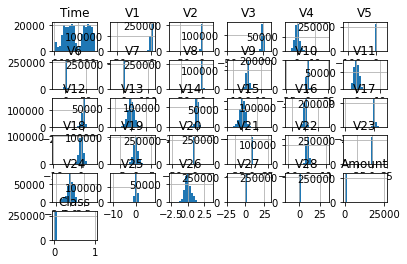

In [2]:
data = pd.read_csv("creditcard.csv")   
histogram = data.hist(bins=20)

data

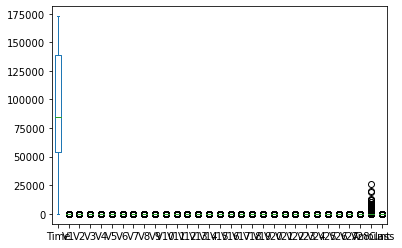

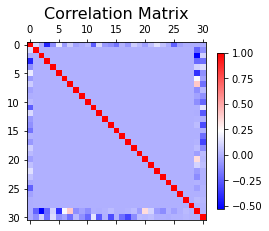

In [3]:
# See: 'Time' and 'Amount' are bigger than other features V1, ..., V28 values
data.plot.box()


# See: features V1, ..., V28 are not correlated as they are the principal components obtained with PCA
plt.matshow(data.corr(), cmap='bwr')
cb = plt.colorbar(shrink=0.7)
plt.title('Correlation Matrix', fontsize=16) 
plt.show()

# Data preprocessing

The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (fraud) accounts for 0.172% of all transactions.
In the case of unbalanced data, the model tends to be biased toward the majority (normal) class, leading to poor performance on the minority (fraud) class. Here are some strategies to address the issue of imbalanced data:

- __Resampling Techniques:__</br>
a. _Undersampling_: Randomly draw a subsample from the majority class to balance the dataset. However, undersampling may lead to loss of information and can be problematic if the dataset is already small. </br>
b. _Oversampling_: Duplicating or creating synthetic samples for the minority class to increase its representation. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) generate synthetic samples by interpolating between existing samples.

- __Class Weighting:__</br>
Assigning higher weights to the minority class during model training to make it more influential. This ensures that the model pays more attention to the minority class and adjusts its decision boundary accordingly.

__In this notebook, we are applying an undersampling technique.__

## (i) separating normal and fraud cases

In [4]:

normal = data[data.Class==0] # Set of all normal (y = 0) cases
fraud = data[data.Class==1]  # Set of all fraud (y = 1) cases


num_normal = normal.shape[0] 
num_fraud = fraud.shape[0] 

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")


ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')


Number of normal examples = 284315
Number of fraud examples = 492

normal to fraud ratio in the whole data = 577.88


## (ii) sample building by choosing a normal_fraud_ratio

In [5]:
'A choice of normal_fraud_ratio has effects on precision and recall given below.'

normal_fraud_ratio = 1                                      # normal_fraud_ratio = 1 means balance sample
normal_sample = normal.sample(normal_fraud_ratio*num_fraud) 


# joining row-wise (axis=0) normal and fraud cases to get a sample 
sample = pd.concat([fraud, normal_sample], axis=0)  


for i in range(100):
    sample = np.random.permutation(sample)                   # random shuffling of sample examples 100 times


    
#==============================================================================


X, y = sample[:, :-1], sample[:, -1]

X = MinMaxScaler().fit_transform(X)            # this will put all the feature (X) values in the interval [0,1]

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)


X[:3,:], y[:3]                                 # see first 3 examples

number of examples =  984
number of features =  30


(array([[0.799654  , 0.9042542 , 0.30878097, 0.87216291, 0.17689391,
         0.70432861, 0.46194234, 0.90724728, 0.67730693, 0.59929437,
         0.62528883, 0.18919451, 0.929819  , 0.43408291, 0.87792613,
         0.33976897, 0.82490909, 0.75956828, 0.72573299, 0.34814776,
         0.24936386, 0.45942438, 0.53535682, 0.76901085, 0.44587214,
         0.71142537, 0.19760418, 0.70149432, 0.60429296, 0.01410717],
        [0.45676102, 0.82936556, 0.35864431, 0.89303962, 0.17398605,
         0.62265841, 0.44473911, 0.86746859, 0.69917955, 0.65561001,
         0.68068526, 0.27687817, 0.9216862 , 0.27421954, 0.88176406,
         0.67264524, 0.85894299, 0.78632791, 0.70021466, 0.29922671,
         0.29737029, 0.4535713 , 0.50594769, 0.78685746, 0.44363534,
         0.65991559, 0.498101  , 0.71045559, 0.54380568, 0.00213089],
        [0.77413325, 0.91412757, 0.2441217 , 0.942395  , 0.13729228,
         0.62215728, 0.51650762, 0.87482329, 0.67880932, 0.65730144,
         0.64257872, 0.06826882,

In [6]:
''' 
Zero padding is to make the number of features equal to a power of 2.
it is required for 'amplitude encoding' given below.
'''

n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)


(number of qubits, dimension of the Hilbert space) = (5, 32)
number of examples =  984
number of features =  32


## (iii) train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape)

(688, 32) (296, 32)


$ $

# Quantum Machine Learning

use either angle or amplitude feature encoding.
__When the number of features is large (say, more than 6), use amplitude encoding.__

## (1a) Feature Map (FM): angle encoding

In [ ]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap


fm = ZZFeatureMap(feature_dimension=num_features, reps=1)                   # ZZFeatureMap seems better
fm.decompose().draw() 


## (1b) Feature Map (FM): [amplitude encoding](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.circuit.library.RawFeatureVector.html)

__Zero padding given above is needed for this encoding.__

In [8]:
from qiskit_machine_learning.circuit.library import RawFeatureVector


fm = RawFeatureVector(feature_dimension=num_features) 
fm.draw() 

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_1: ┤1                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_2: ┤2 Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15],x[16],x[17],x[18],x[19],x[20],x[21],x[22],x[23],x[24],x[25],x[26],x[27],x[28],x[29],x[30],x[31]) ├
«     │                                                                                                                                                                                                                 │
«q_3: ┤3                                                                                                                                                                                                                ├
«     │                                                                                                                                                                                                                 │
«q_4: ┤4                                                                                                                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

## (2) Parameterized Quantum Circuit (PQC)

In [9]:
from qiskit.circuit.library import RealAmplitudes


'''
For angle encoding, num_qubits = num_features
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=n, reps=3)
pqc.decompose().draw()


┌──────────┐                                          ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──────────────────────────────────■───────┤ Ry(θ[5]) ├»
     ├──────────┤                                ┌─┴─┐     ├──────────┤»
q_1: ┤ Ry(θ[1]) ├──────────────────────■─────────┤ X ├─────┤ Ry(θ[6]) ├»
     ├──────────┤                    ┌─┴─┐    ┌──┴───┴───┐ └──────────┘»
q_2: ┤ Ry(θ[2]) ├──────────■─────────┤ X ├────┤ Ry(θ[7]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_3: ┤ Ry(θ[3]) ├──■─────┤ X ├────┤ Ry(θ[8]) ├─────■──────────┤ X ├────»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘   ┌─┴─┐    ┌───┴───┴───┐»
q_4: ┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[9]) ├───────────────┤ X ├────┤ Ry(θ[14]) ├»
     └──────────┘└───┘└──────────┘               └───┘    └───────────┘»
«                               ┌───────────┐                          »
«q_0: ───────────────────■──────┤ Ry(θ[10]) ├───────────────────■──────»
«                      ┌─┴─┐    ├───────────┤                 ┌─┴─┐    »
«q_1: ──────■──────────┤ X ├────┤ Ry(θ[11]) ├──────■──────────┤ X ├────»
«         ┌─┴─┐    ┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐»
«q_2: ────┤ X ├────┤ Ry(θ[12]) ├──────■──────────┤ X ├────┤ Ry(θ[17]) ├»
«     ┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘»
«q_3: ┤ Ry(θ[13]) ├──────■──────────┤ X ├────┤ Ry(θ[18]) ├─────────────»
«     └───────────┘    ┌─┴─┐    ┌───┴───┴───┐└───────────┘             »
«q_4: ─────────────────┤ X ├────┤ Ry(θ[19]) ├──────────────────────────»
«                      └───┘    └───────────┘                          »
«     ┌───────────┐
«q_0: ┤ Ry(θ[15]) ├
«     ├───────────┤
«q_1: ┤ Ry(θ[16]) ├
«     └───────────┘
«q_2: ─────────────
«                  
«q_3: ─────────────
«                  
«q_4: ─────────────
«

## (3) Build the model: [Variational Quantum Classifier (VQC)](https://qiskit.org/documentation/stable/0.19/stubs/qiskit.aqua.algorithms.VQC.html#qiskit.aqua.algorithms.VQC) with FM and PQC


__[Sampler](https://qiskit.org/documentation/apidoc/primitives.html) class calculates probabilities or quasi-probabilities of bitstrings from quantum circuits.__
A sampler is initialized with an empty parameter set. The sampler is used to create a JobV1, via the qiskit.primitives.Sampler.run() method, and yields a SamplerResult object, which contains probabilities or quasi-probabilities of bitstrings, plus optional metadata like error bars in the samples.


In [10]:
from qiskit.algorithms.optimizers import COBYLA

# This defines where to train our classifier: on a simulator or a real quantum computer
from qiskit.primitives import Sampler                             # here we have chosen a simulator 

from qiskit_machine_learning.algorithms.classifiers import VQC    # !pip install qiskit[machine-learning]


#------------------------------------------------------------------------------------------------

optimizer = COBYLA(maxiter=150)                 # maxiter = Maximum number of iterations (function evaluations)
sampler = Sampler()

#------------------------------------------------------------------------------------------------

from IPython.display import clear_output
objective_func_vals = []
                                    # a callback that can access the intermediate data during the optimization
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#------------------------------------------------------------------------------------------------

vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

## (4) Training VQC ...

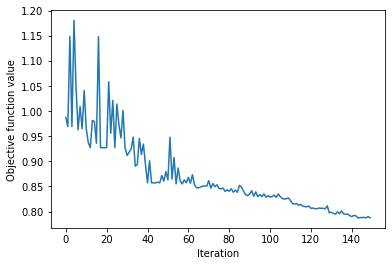

CPU times: user 9min 24s, sys: 27.2 s, total: 9min 51s
Wall time: 9min 16s


In [11]:
%%time

'''Training time seems to increase with the number of features'''

vqc.fit(X_train, y_train)

## (5) performance evaluation of trained VQC

In imbalanced datasets, accuracy alone is not a reliable performance metric. It can be misleading due to the dominance of the majority class. Instead, focus on evaluation metrics like precision, recall, F1-score, or area under the Receiver Operating Characteristic (ROC) curve, which provide a more comprehensive assessment of the model's performance on both classes.

More Area Under the Receiver Operating Characteristic Curve (__ROC AUC__) better classifier.

In [20]:

y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")
print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")


              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90       343
         1.0       1.00      0.78      0.87       345

    accuracy                           0.89       688
   macro avg       0.91      0.89      0.89       688
weighted avg       0.91      0.89      0.89       688

[[343   0]
 [ 77 268]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88       149
         1.0       1.00      0.72      0.84       147

    accuracy                           0.86       296
   macro avg       0.89      0.86      0.86       296
weighted avg       0.89      0.86      0.86       296

[[149   0]
 [ 41 106]] = confusion matrix for test set 
 
0.86 = roc_auc_score for test set 



$ $

$ $

# Classical Machine Learning (ML) models with [scikit-learn](https://scikit-learn.org/stable/)

In [12]:
%%time
warnings.filterwarnings('ignore')

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train)                          # fit model
    
    y_train_pred = ML_model.predict(X_train)       # predict with the trained model
    y_test_pred = ML_model.predict(X_test)
    
    
    print(classification_report(y_train, y_train_pred))     # evaluate model performance 
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    print(round(roc_auc_score(y_test, y_test_pred),2), "= roc_auc_score for test set \n")
    
    print(70*'=')
    

#----------------------------------------------------------------------------------

print(70*'=')
ML_model = linear_model.LogisticRegression()            # create model instance
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)


                     LogisticRegression() 

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       348
         1.0       1.00      0.86      0.92       340

    accuracy                           0.93       688
   macro avg       0.94      0.93      0.93       688
weighted avg       0.94      0.93      0.93       688

[[347   1]
 [ 47 293]] = confusion matrix for train set 

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       144
         1.0       0.99      0.89      0.94       152

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

[[143   1]
 [ 17 135]] = confusion matrix for test set 

0.94 = roc_auc_score for test set 

                     MLPClassifier() 

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       348
   

# $ $




$ $